# Understanding the Role of Gender in Book Reviews

## CS 6471: Computational Social Science - Project
Author: Pratyusha Maiti

Affiliation: Georgia Institute of Technology

### Research Objectives
- Do book reviews by different genders differ in stylistic features?
- Do book reviews by different genders differ w.r.t their content?
- Are book reviews written by males perceived as more useful than book reviews written by females?

## 0. Set Up

In [15]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
!pip install contractions
!pip install tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pratyushamaiti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pratyushamaiti/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pratyushamaiti/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/pratyushamaiti/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/pratyushamaiti/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


You should consider upgrading via the '/opt/homebrew/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/homebrew/anaconda3/bin/python -m pip install --upgrade pip' command.


## 1. Review Data Cleaning

Parameters:
 - Expand contractions
 - Remove stopwords
 - Remove junk and html
 - Tokenize
 - Lemmatize
 

In [10]:
import contractions 
import re
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt 

Tweak the below parameters as you like. We are keeping stopwords at this point to study the use of hedge words and pronouns in the review text.

In [3]:
expand_contractions = True
remove_stopwords = False
format_text = True
tokenize = True
lemmatize = False

def clean_text(text):
    '''Text Preprocessing '''
    
    # Convert words to lower case
    text = text.lower()
    split_text = text.split()
    
    # Expand contractions
    if expand_contractions:
        expanded_words = []   
        for word in split_text:
            expanded_words.append(contractions.fix(word))
        text = " ".join(expanded_words)

    # Format words and remove unwanted characters
    if format_text:
        text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        text = re.sub(r'\<a href', ' ', text)
        text = re.sub(r'&amp;', '', text) 
        text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
        text = re.sub(r'<br />', ' ', text)
        text = re.sub(r'\'', ' ', text)
    
    # remove stopwords
    if remove_stopwords:
        split_text = text.split()
        stops = set(stopwords.words("english"))
        word = [w for w in split_text if not w in stops]
        text = " ".join(word)

    # Tokenize each word
    if tokenize:
        text =  nltk.WordPunctTokenizer().tokenize(text)
    
    # Lemmatize each token
    if lemmatize:
        lemm = nltk.stem.WordNetLemmatizer()
        text = list(map(lambda word:list(map(lemm.lemmatize, word)), text))
    
    return text

### 1.1 Combine review data and gender info

The original dataset consists of anonymized names and reviews, but a mapping to the original user-id on Goodreads has been provided. Using the mapping and Goodreads API, we obtain the First Names of the reviewers and use gender_guesser to map the first names to possible genders. The final gender info is stored in goodreads_names_id_gender.csv. 

In [4]:
import pandas as pd
gendered_data = pd.read_csv('goodreads_names_id_gender.csv')
gendered_data.columns = ['id', 'name', 'username', 'age', 'location', 'joined', 'friends_count','groups_count', 'reviews_count', 'first_name', 'gender', 'user_id']
gendered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852197 entries, 0 to 852196
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             852197 non-null  int64  
 1   name           850616 non-null  object 
 2   username       252735 non-null  object 
 3   age            242043 non-null  float64
 4   location       665382 non-null  object 
 5   joined         820599 non-null  object 
 6   friends_count  820599 non-null  float64
 7   groups_count   820599 non-null  float64
 8   reviews_count  820599 non-null  float64
 9   first_name     850555 non-null  object 
 10  gender         852197 non-null  object 
 11  user_id        852197 non-null  object 
dtypes: float64(4), int64(1), object(7)
memory usage: 78.0+ MB


### 1.2 Merge and clean the gender and review data

- Merge pd dfs for review data and gender info based on user ID
- Drop the rows where gender is unknown

In [6]:
import gzip
import json

def load_data(file_name, head = 500):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
            
            # break if reaches the 100th line
            if (head is not None) and (count > head):
                break
    return data

goodreads_reviews_mystery_thriller_crime = load_data('goodreads_reviews_mystery_thriller_crime.json.gz',1849235)
goodreads_reviews_mystery_thriller_crime_df = pd.DataFrame(goodreads_reviews_mystery_thriller_crime)

gendered_reviews_mtc = pd.merge(goodreads_reviews_mystery_thriller_crime_df, gendered_data, on='user_id', how='left')

gendered_reviews_mtc = gendered_reviews_mtc[gendered_reviews_mtc.gender != 'unknown']
gendered_reviews_mtc = gendered_reviews_mtc.dropna(subset=['gender'])
gendered_reviews_mtc = gendered_reviews_mtc.reset_index(drop=True)
gendered_reviews_mtc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267740 entries, 0 to 1267739
Data columns (total 22 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   user_id        1267740 non-null  object 
 1   book_id        1267740 non-null  object 
 2   review_id      1267740 non-null  object 
 3   rating         1267740 non-null  int64  
 4   review_text    1267740 non-null  object 
 5   date_added     1267740 non-null  object 
 6   date_updated   1267740 non-null  object 
 7   read_at        1267740 non-null  object 
 8   started_at     1267740 non-null  object 
 9   n_votes        1267740 non-null  int64  
 10  n_comments     1267740 non-null  int64  
 11  id             1267740 non-null  float64
 12  name           1267740 non-null  object 
 13  username       647310 non-null   object 
 14  age            582643 non-null   float64
 15  location       915311 non-null   object 
 16  joined         1202883 non-null  object 
 17  friends_

**Note: First takeaway is that the Goodreads gender ratio is highly skewed as shown below:**

female    954765
male      312975
Name: gender, dtype: int64


<AxesSubplot:ylabel='gender'>

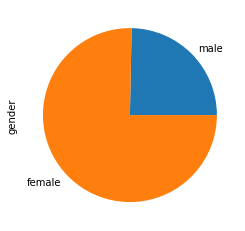

In [24]:
print(gendered_reviews_mtc['gender'].value_counts())
gendered_reviews_mtc.gender.value_counts().sort_values().plot(kind = 'pie')

### 1.3 Generate cleaned review data

- Run clean_text function on a subset of review data and use it for subsequent analysis.
- For now, we select gender balanced data of 30,000 reviews (15,000 reviews by each gender) and randomise the content

In [20]:
from tqdm import tqdm

def clean_review(reviews_set):
    pd.options.mode.chained_assignment = None
    for idx in tqdm(range(reviews_set.shape[0])):
        reviews_set['review_text'][idx] = ' '.join(clean_text(reviews_set['review_text'][idx]))

In [18]:
male_reviews = gendered_reviews_mtc.loc[gendered_reviews_mtc['gender'] == "male"]
male_reviews = male_reviews.reset_index(drop=True)
female_reviews = gendered_reviews_mtc.loc[gendered_reviews_mtc['gender'] == "female"]
female_reviews = female_reviews.reset_index(drop=True)

train_frames = [male_reviews[:15000], female_reviews[:15000]]
train_balanced_reviews_mtc = pd.concat(train_frames)
train_balanced_reviews_mtc = train_balanced_reviews_mtc.reset_index(drop=True)

test_frames = [male_reviews[15000:20000], female_reviews[15000:20000]]
test_balanced_reviews_mtc = pd.concat(test_frames)
test_balanced_reviews_mtc = test_balanced_reviews_mtc.reset_index(drop=True)

train_balanced_reviews_mtc.reindex(np.random.permutation(train_balanced_reviews_mtc.index))
test_balanced_reviews_mtc.reindex(np.random.permutation(test_balanced_reviews_mtc.index))

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,...,name,username,age,location,joined,friends_count,groups_count,reviews_count,first_name,gender
9199,c056c790208c11cdc8918cef11021994,6367212,9032de4b02cd170d3a52f9ccd29e3870,4,This one has as many pages of recipes as it do...,Tue May 14 19:28:41 -0700 2013,Mon Dec 30 19:51:57 -0800 2013,Sun Dec 29 00:00:00 -0800 2013,Sat Dec 28 00:00:00 -0800 2013,0,...,Danielle,NaN,66.0,"Drexel Hill, PA",06/2012,171.0,2.0,2915.0,danielle,female
1987,a5d71d72f84951be42b5b99c556f2ece,913407,9944f6271441280bf5d3157b02d27111,5,"When you run a business and problems pop up, y...",Tue Dec 11 02:00:01 -0800 2012,Fri Dec 28 16:13:18 -0800 2012,Sat Dec 15 00:00:00 -0800 2012,Tue Dec 11 00:00:00 -0800 2012,2,...,William,NaN,74.0,"San Francisco, CA",08/2012,132.0,3.0,257.0,william,male
378,b7a5d8d2a5e87321be5ee8acf4113442,13418925,a7be93dc37b448e37200a515298e66e9,5,GREAT BOOK!!!! Jennifer does it again with thi...,Tue Mar 19 13:58:47 -0700 2013,Wed Apr 02 02:45:22 -0700 2014,Wed Apr 02 02:45:22 -0700 2014,,0,...,TAM,NaN,NaN,NaN,08/2012,18.0,3.0,2673.0,tam,male
2961,c97f0ab5c4396b54b31282a1e2f7cb12,29904284,56b7260c50ed0f785b4e196d2a63e30a,2,It was a different way to pose the question of...,Fri Nov 25 10:25:59 -0800 2016,Fri Nov 25 10:43:31 -0800 2016,Thu Nov 24 00:00:00 -0800 2016,Sat Nov 05 00:00:00 -0700 2016,0,...,Nicky,NaN,47.0,"Las Cruces, NM",08/2012,82.0,1.0,762.0,nicky,male
2451,862c45468e68b1c400808577c010e921,18693623,2812b72a7a1905d756c73d5605d646a5,4,Enjoyable read - Barclay is a good story teller.,Tue Sep 29 07:10:48 -0700 2015,Thu Oct 08 02:04:35 -0700 2015,Thu Oct 08 02:04:35 -0700 2015,Tue Sep 29 00:00:00 -0700 2015,0,...,Lionel Denny,NaN,73.0,NaN,08/2012,3.0,1.0,378.0,lionel,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2698,c715cf98e9f8bf483cad3a633411acfa,6054393,3dcbdebf9a43bab0b94bab9af6f1c0f7,4,A non-mystery about the relationship between a...,Thu Feb 18 09:58:32 -0800 2010,Wed Sep 08 11:21:26 -0700 2010,Wed Sep 08 00:00:00 -0700 2010,Tue Sep 07 00:00:00 -0700 2010,0,...,Ed,NaN,NaN,"New York, NY",06/2008,58.0,1.0,907.0,ed,male
6989,5fa6d9466eede95cdafb8c86b8f517da,43926,cd0836eeea4fc9b35a8de49d8741526d,3,"Matt Hunter has built a wonderful new life, ha...",Thu Nov 08 13:14:17 -0800 2012,Thu Nov 08 13:28:58 -0800 2012,Thu Nov 01 00:00:00 -0700 2012,Mon Oct 15 00:00:00 -0700 2012,1,...,Linda,katknit,NaN,"Coventry, CT",04/2008,278.0,3.0,1923.0,linda,female
4093,26538f0f360954a65d7ef0dff0624a96,29249685,d4147902a0a427c60c3a5e4c33ec9d40,2,This was OK up until he raped Candy's lesbian ...,Sun Dec 11 16:25:28 -0800 2016,Sat Mar 25 17:41:16 -0700 2017,Sat Mar 25 17:39:58 -0700 2017,Tue Mar 21 18:56:32 -0700 2017,0,...,Patrick,NaN,NaN,"Detroit, MI",06/2008,451.0,12.0,2201.0,patrick,male
2194,9f8f8bfb36f36e09f05ec009c5f1d7f0,27694,237adaf354cb8ce02fb9b06f1697bcf2,4,Reading this right on the tail of My Brother M...,Mon Jan 27 14:22:06 -0800 2014,Wed May 07 12:31:22 -0700 2014,Fri Jan 31 00:00:00 -0800 2014,Mon Jan 27 00:00:00 -0800 2014,0,...,Michiel,NaN,56.0,"Parkersburg, WV",08/2012,34.0,2.0,1425.0,michiel,male


In [22]:
clean_review(train_balanced_reviews_mtc)
clean_review(test_balanced_reviews_mtc)

100%|██████████| 10000/10000 [00:04<00:00, 2291.46it/s]


In [23]:
train_file_name = "train_mtc.csv"
test_file_name = "test_mtc.csv"
train_balanced_reviews_mtc.to_csv(train_file_name, sep='\t')
test_balanced_reviews_mtc.to_csv(test_file_name, sep='\t')

## 2. Model Setup

- Logistic Regression model for analysing performance in predicting gender 
- Metrics used to measure performance:
    - Accuracy
    - Log Odds?
    - MSE
    - RMSE
    
The values output for metrics in this section are default values taking a dummy feature set of all zeroes.

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss,accuracy_score
import sklearn.metrics as metrics

In [122]:
a = np.zeros(shape=(40000, 1))
feature_df = pd.DataFrame(a,columns=['dummy'])

In [140]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    logLoss = metrics.log_loss(y_true, y_pred)
#     f1=metrics.f1_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('log loss: ', round(logLoss,4)) 
#     print('f1: ', round(f1,4))
#     print('MAE: ', round(mean_absolute_error,4))
#     print('MSE: ', round(mse,4))
#     print('RMSE: ', round(np.sqrt(mse),4))

In [137]:
def call_model():
    Y_train=train_balanced_reviews_mtc['gender'].values
    Y_test=test_balanced_reviews_mtc['gender'].values

    scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=10000)
    model=scikit_log_reg.fit(feature_df[:30000],Y_train)

    predicted = model.predict(feature_df[30000:])
    probs = model.predict_proba(feature_df[30000:])

    y_test_n = [0 if y == "male" else 1 for y in Y_test]
    probs_n = [i[0] for i in probs]
    print("Model %s vs Gender" % (feature_df.columns[0]))
    print(("Accuracy  ") + str(accuracy_score(Y_test, predicted)))
    plt.plot(probs_n, feature_df[30000:]) 
    plt.xlabel("Prediction Probability")
    plt.ylabel("Feature Values")
    return regression_results(y_test_n, probs_n)


[LibLinear]Model dummy vs Gender
Accuracy  0.5
explained_variance:  0.0
mean_squared_log_error:  0.1236
r2:  0.0
log loss:  0.6931


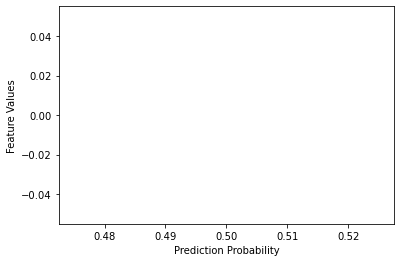

In [123]:
call_model()

## 3. Writing Style Analysis

#### Features under analysis:
- lexical_markers 
- vocabulary_richness
- complexity 
- hedging
- use_of_pronouns


In [33]:
from collections import Counter
from nltk.probability import FreqDist
import math 
from nltk.tokenize import sent_tokenize
from nltk import word_tokenize, pos_tag

def get_pronouns(reviews_set):
    pos_pronouns = []
    for idx in tqdm(range(reviews_set.shape[0])):
        if len(reviews_set['review_text'][idx])>0:
            pos_pronouns.append(sum(1 for word, pos in pos_tag(word_tokenize(reviews_set['review_text'][idx])) if pos.startswith('PR') or word == "i"))
        else:
            pos_pronouns.append(0)
#     print(len(pos_pronouns))
    return pos_pronouns

def avg_wordLength(text):
    return np.average([len(word) for word in text.split()])

def avg_SentLenghtByCh(text):
    tokens = sent_tokenize(text)
    return np.average([len(token) for token in tokens])

def avg_SentLenghtByWord(text):
    tokens = sent_tokenize(text)
    return np.average([len(token.split()) for token in tokens])

def get_complexity(reviews_set):
    complexity_1 = []
    complexity_2 = []
    complexity_3 = []
    for idx in tqdm(range(reviews_set.shape[0])):
        if len(reviews_set['review_text'][idx])>0:
            complexity_1.append(avg_wordLength(reviews_set['review_text'][idx]))
            complexity_2.append(avg_SentLenghtByCh(reviews_set['review_text'][idx]))
            complexity_3.append(avg_SentLenghtByWord(reviews_set['review_text'][idx]))  
        else:
            complexity_1.append(0)
            complexity_2.append(0)
            complexity_3.append(0)
#     print(len(complexity_1), len(complexity_2), len(complexity_3))
    return complexity_1, complexity_2, complexity_3

def topN_Freq(data, n: int):
    fdist = FreqDist(data)
    return fdist.most_common(n)

def top_50_words(reviews_set):
    top_50 = {}
    dic2 = {}
    for idx in tqdm(range(reviews_set.shape[0])):

        freqDict = topN_Freq(reviews_set['review_text'][idx].split(), 50)
        dic1 = dict(freqDict)
        if idx != 0:
            top_50 = {k: dic1.get(k, 0) + dic2.get(k, 0) for k in set(dic1) | set(dic2)}
        dic2 = dict(Counter(top_50).most_common(50))
#     print(len(top_50))
    return dict(Counter(top_50).most_common(50))

def get_lexical_markers(reviews_set):
    lexical_markers = []
    top_50 = top_50_words(train_balanced_reviews_mtc)
    
    for idx in tqdm(range(reviews_set.shape[0])):
        freq = Counter(reviews_set['review_text'][idx].split())
        lexical_markers.append(sum(freq.get(k, 0) for k in set(top_50)))
#     print(len(lexical_markers))
    return lexical_markers

def get_hedge_words(reviews_set):
    hedgefile = open("hedgeWords.txt", "r")
    content = hedgefile.read()
    hedgeWords = content.split("\n")
    hedgefile.close()
    hedging = []
    for idx in tqdm(range(reviews_set.shape[0])):
        hedging.append(sum(1 for x in word_tokenize(reviews_set['review_text'][idx]) if x in hedgeWords))
#     print(len(hedging))
    return hedging

def yulesCharacteristicK(words):
    N = len(words)
    K=0
    if N>0:
        freqs = Counter()
        freqs.update(words)
        vi = Counter()
        vi.update(freqs.values())
        M = sum([(value * value) * vi[value] for key, value in freqs.items()])
        K = 10000 * (M - N) / math.pow(N, 2)
    return K

def get_vocabulary_richness(reviews_set):
    vocabulary_richness = []
    for idx in tqdm(range(reviews_set.shape[0])):
        vocabulary_richness.append(yulesCharacteristicK(reviews_set['review_text'][idx]))
#     print(len(vocabulary_richness))
    return vocabulary_richness



In [34]:
f_lexical_markers = []
f_lexical_markers.extend(get_lexical_markers(train_balanced_reviews_mtc))
f_lexical_markers.extend(get_lexical_markers(test_balanced_reviews_mtc))

f_hedging = []
f_hedging.extend(get_hedge_words(train_balanced_reviews_mtc))
f_hedging.extend(get_hedge_words(test_balanced_reviews_mtc))

f_vocabulary_richness = []
f_vocabulary_richness.extend(get_vocabulary_richness(train_balanced_reviews_mtc))
f_vocabulary_richness.extend(get_vocabulary_richness(test_balanced_reviews_mtc))

complexity_1, complexity_2, complexity_3 = get_complexity(train_balanced_reviews_mtc)
complexity_1_t, complexity_2_t, complexity_3_t = get_complexity(test_balanced_reviews_mtc)
complexity_1.extend(complexity_1_t)
complexity_2.extend(complexity_2_t)
complexity_3.extend(complexity_3_t)

f_pronouns = []
f_pronouns.extend(get_pronouns(train_balanced_reviews_mtc))
f_pronouns.extend(get_pronouns(test_balanced_reviews_mtc))

100%|██████████| 10000/10000 [00:31<00:00, 322.05it/s]


In [100]:
# f_pronouns

In [97]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   pronoun  0 non-null      bool 
dtypes: bool(1)
memory usage: 0.0+ bytes


In [138]:
def generate_writing_style_feature_set(feature_df):
    f_lexical = True
    f_complexity = False
    f_vocab_richness = False
    f_hedg = False
    f_pron = False
    if f_lexical:
        feature_df['Lexical Markers'] = f_lexical_markers
    if f_complexity:
        feature_df['Complecity'] = complexity_1
        feature_df['comp2'] = complexity_2
        feature_df['comp3'] = complexity_3
    if f_vocab_richness:
        feature_df['Vocab Richness'] = f_vocabulary_richness
    if f_hedg:
        feature_df['Hedging'] = f_hedging
    if f_pron:
        feature_df['Pronouns'] = f_pronouns

### 3.1 Single features vs gender prediction

#### 3.1.1 Only Lexical Markers

[LibLinear]Model Lexical Markers vs Gender
Accuracy  0.5433
explained_variance:  0.0009
mean_squared_log_error:  0.1233
r2:  0.0008
log loss:  0.6927


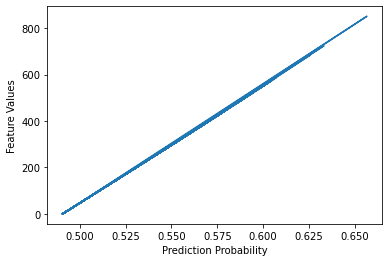

In [141]:
feature_df = pd.DataFrame() 
generate_writing_style_feature_set(feature_df)
call_model()

#### 3.1.2 Only pronouns

[LibLinear]Model Pronouns vs Gender
Accuracy  0.548
explained_variance:  0.0052
mean_squared_log_error:  0.1224
r2:  0.005
log loss:  0.6909


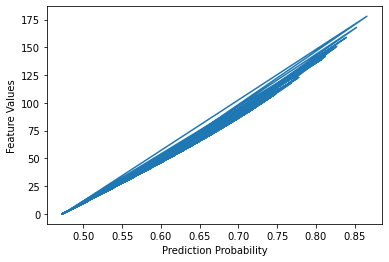

In [128]:
feature_df = pd.DataFrame() 
generate_writing_style_feature_set(feature_df)
call_model()

#### 3.1.3 Only hedging

[LibLinear]Model Hedging vs Gender
Accuracy  0.5407
explained_variance:  0.0015
mean_squared_log_error:  0.1231
r2:  0.0014
log loss:  0.6925


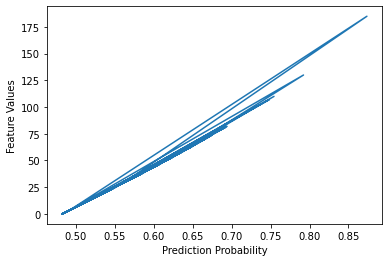

In [130]:
feature_df = pd.DataFrame() 
generate_writing_style_feature_set(feature_df)
call_model()

#### 3.1.4 Only vocab richness

[LibLinear]Model Vocab Richness vs Gender
Accuracy  0.4735
explained_variance:  -0.0005
mean_squared_log_error:  0.1236
r2:  -0.0005
log loss:  0.6934


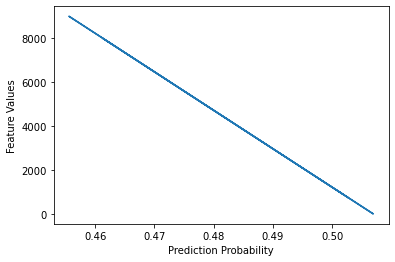

In [134]:
feature_df = pd.DataFrame() 
generate_writing_style_feature_set(feature_df)
call_model()

#### 3.1.5 Only complexity

[LibLinear]Model Complecity vs Gender
Accuracy  0.5338
explained_variance:  0.0037
mean_squared_log_error:  0.1226
r2:  0.0035
log loss:  0.6916


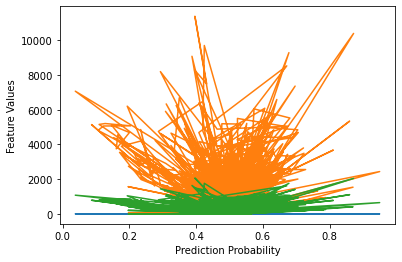

In [132]:
feature_df = pd.DataFrame() 
generate_writing_style_feature_set(feature_df)
call_model()

### 3.2 Combination of features vs gender prediction

## 4. Content Analysis

#### Features under analysis:
- Shannon Entropy: uniqueness of text
- Simpson Index: diversity in text
- Brunet’s Index: lexical richness 


In [143]:
import scipy as sc

def ShannonEntropy(words):
    if len(words) == 0:
        return 0
    freqs = Counter()
    freqs.update(words)
    arr = np.array(list(freqs.values()))
    distribution = 1. * arr
    distribution /= max(1, len(words))
    
    H = sc.stats.entropy(distribution, base=2)
    return H

def SimpsonsIndex(words):
    if len(words) < 2:
        return 0
    freqs = Counter()
    freqs.update(words)
    N = len(words)
    n = sum([1.0 * i * (i - 1) for i in freqs.values()])
    D = 1 - (n / (N * (N - 1)))
    return D

def BrunetsMeasureW(words):
    if len(words) < 2:
        return 0
    a = 0.17
    V = float(len(set(words)))
    N = len(words)
    B = (V - a) / (math.log(N))
    return B

entropy = []
simpsons = []
brunets = []

for idx in tqdm(range(train_balanced_reviews_mtc.shape[0])):
    entropy.append(ShannonEntropy(train_balanced_reviews_mtc['review_text'][idx]))
    simpsons.append(SimpsonsIndex(train_balanced_reviews_mtc['review_text'][idx]))
    brunets.append(BrunetsMeasureW(train_balanced_reviews_mtc['review_text'][idx]))

for idx in tqdm(range(test_balanced_reviews_mtc.shape[0])):
    entropy.append(ShannonEntropy(test_balanced_reviews_mtc['review_text'][idx]))
    simpsons.append(SimpsonsIndex(test_balanced_reviews_mtc['review_text'][idx]))
    brunets.append(BrunetsMeasureW(test_balanced_reviews_mtc['review_text'][idx]))
        
len(entropy), len(simpsons), len(brunets)

100%|██████████| 10000/10000 [00:00<00:00, 13197.91it/s]


(40000, 40000, 40000)

In [149]:
def generate_content_feature_set(feature_df):
    f_shannon = False
    f_simpson = False
    f_brunet = True
    if f_shannon:
        feature_df['Entropy'] = entropy
    if f_simpson:
        feature_df['Simpsons'] = simpsons
    if f_brunet:
        feature_df['Brunets'] = brunets

### 4.1 Single Values vs Gender

[LibLinear]Model Entropy vs Gender
Accuracy  0.4756
explained_variance:  -0.0
mean_squared_log_error:  0.1236
r2:  -0.0
log loss:  0.6932


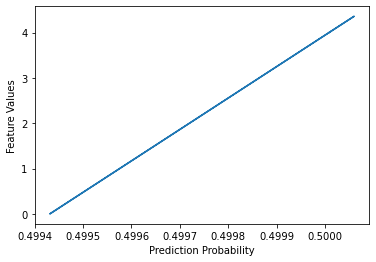

In [146]:
feature_df = pd.DataFrame() 
generate_content_feature_set(feature_df)
call_model()

[LibLinear]Model Simpsons vs Gender
Accuracy  0.5293
explained_variance:  0.0052
mean_squared_log_error:  0.1231
r2:  0.0052
log loss:  0.6903


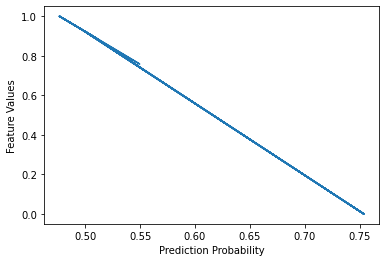

In [148]:
feature_df = pd.DataFrame() 
generate_content_feature_set(feature_df)
call_model()

[LibLinear]Model Brunets vs Gender
Accuracy  0.5484
explained_variance:  0.0009
mean_squared_log_error:  0.1235
r2:  0.0009
log loss:  0.6927


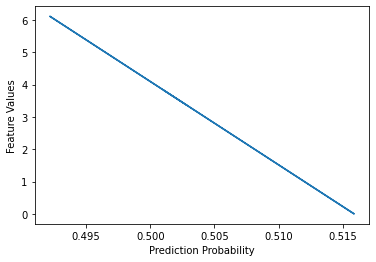

In [150]:
feature_df = pd.DataFrame() 
generate_content_feature_set(feature_df)
call_model()

### 4.2 Combination vs Gender

## 5 PCA